In [1]:
import torch
import gym
import numpy as np
from DDPG_agent import Agent,ReplayBuffer
from tqdm import trange
import matplotlib.pyplot as plt

!pip3 install box2d-py==2.3.8

In [2]:
def fill_replay_buffer(env,replay_buffer, observation_steps):
    time_steps = 0
    state = env.reset()
    done = False
    while time_steps < observation_steps:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, next_state, action, reward, done))
        state = next_state
        time_steps += 1
        if done:
            state = env.reset()
            done = False
        print("\rFilling buffer: {}/{}.".format(time_steps, observation_steps), end="")

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

In [3]:

SEED = 0
REPLAY_SIZE = 30000
n_ep_running_average = 50
n_episodes=1000
max_steps=1000

In [4]:
env = gym.make("LunarLanderContinuous-v2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
policy = Agent(state_dim, action_dim, max_action, env,BATCH_SIZE=64, GAMMA=0.99, TAU=1e-3, NOISE=0.2, NOISE_CLIP=0.5, POLICY_FREQUENCY=2)
replay_buffer = ReplayBuffer()


In [5]:
fill_replay_buffer(env, replay_buffer, REPLAY_SIZE)

Filling buffer: 30000/30000.

Episode 999 - Reward/Steps: 250.6/202 - Avg. Reward/Steps: 196.9/393: 100%|██████████| 1000/1000 [1:37:23<00:00,  5.84s/it]


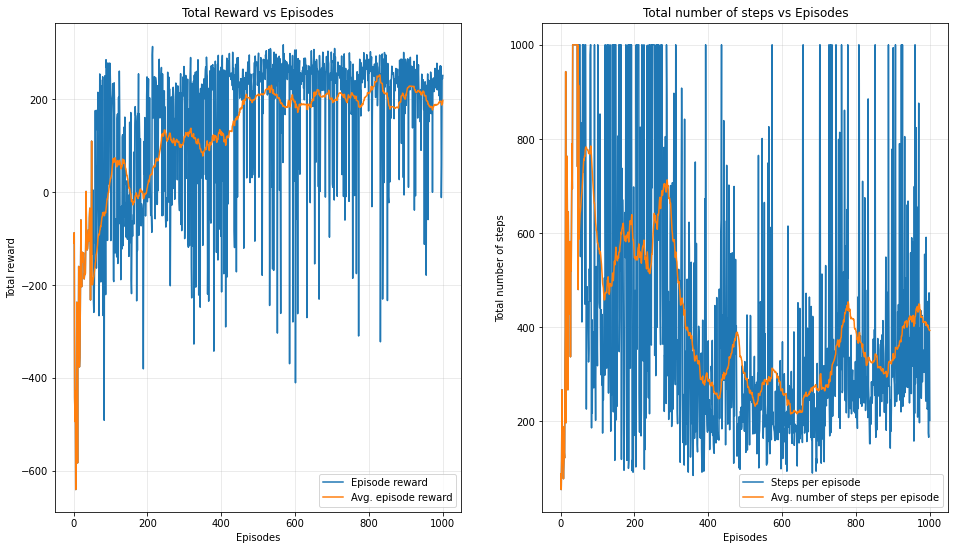

In [6]:
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode
EPISODES = trange(n_episodes, desc='Episode: ', leave=True)

for i in EPISODES:
    state = env.reset()
    total_episode_reward = 0.
    t=0
    for k in range(max_steps):
        action = policy.act(np.array(state), noise=0.1)
        #env.render()
        next_state, reward, done, _ = env.step(action)
        done_bool =  float(done)
        # Store data in replay buffer
        replay_buffer.add((state, next_state, action, reward, done_bool))
        total_episode_reward += reward
        policy.train(replay_buffer,t)
        state = next_state
        t+=1
        if done:
            break 
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    EPISODES.set_description("Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(i, total_episode_reward, t,
    running_average(episode_reward_list, n_ep_running_average)[-1],
    running_average(episode_number_of_steps, n_ep_running_average)[-1]))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, n_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, n_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, n_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, n_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

In [7]:
torch.save(policy.actor.to('cpu'), 'neural-network-2-actor.pth')
torch.save(policy.critic.to('cpu'), 'neural-network-2-critic.pth')

In [10]:
torch.save(policy.actor.state_dict(), 'neural-network-2-actor_state_dict.pth')
torch.save(policy.critic.state_dict(), 'neural-network-2-critic_state_dict.pth')

In [9]:
Results ={}
Results['steps'] = episode_number_of_steps
Results['rewards'] = episode_reward_list
np.save('Plot_data2_finalNetwork.npy',Results)

In [8]:
!python DDPG_check_solution.py

Network model: Actor(
  (fc1): Linear(in_features=8, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=2, bias=True)
)
Checking solution...
Episode 49: 100% 50/50 [00:22<00:00,  2.23it/s]
Policy achieves an average total reward of 232.2 +/- 15.0 with confidence 95%.
Your policy passed the test!
